# Sentiment Analysis on Amazon product review - Text Classification Application 
Yerramaddu Jahnavi - 181CO260 <br>
Swathi J S - 181CO155

The task is to learn the sentiments from all the given reviews and predict the rating from a new review. This objective is attained by following the steps listed below :

### Importing the necessary libraries 

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import future

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords

### Data Description | Loading the Dataset 

In [5]:
data = pd.read_csv("Amazon_Unlocked_Mobile.csv")

PromptCloud extracted 400 thousand reviews of unlocked mobile phones sold on Amazon.com to find out insights with respect to reviews, ratings, price and their relationships.<br>
Given below are the fields of the dataset:<br>
1.Product Title<br>
2.Brand<br>
3.Price<br>
4.Rating<br>
5.Review text<br>
6.Review Votes : Number of people who found the review helpful<br>
Data was acquired in December, 2016 by the crawlers build to deliver our data extraction services.

In [8]:
data

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


In [7]:
data.shape

(413840, 6)

### Data Labeling 

In this step we label the data accordingly:<br>

1.Label = 2, if data["Rating"] >= 4 then Good <br>
2.Label = 1, if data["Rating"] = 3 then Neutral <br>
3.Label = 0, if data["Rating"] < 3 then Poor <br>

In [9]:
labels = []
for instance in data['Rating']:
    if instance >= 4:
        labels.append('2')   #Good
    elif instance == 3:
        labels.append('1')   #Neutral
    else:
        labels.append('0')   #Poor
data['Label'] = labels

In [10]:
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,2
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,2
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,2
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,2
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,2


### Removing unwanted columns of the dataset
The review votes column holds no importance, hence it is needed to be removed.

In [11]:
del data['Review Votes']

### Data Cleaning 
We remove all instances with any blank cell.

In [12]:
print(data.isnull().any())

Product Name    False
Brand Name       True
Price            True
Rating          False
Reviews          True
Label           False
dtype: bool


In [13]:
data.replace('',np.nan,inplace=True)
data.dropna(axis=0,how='any',inplace=True)

In [14]:
print(data.isnull().any())

Product Name    False
Brand Name      False
Price           False
Rating          False
Reviews         False
Label           False
dtype: bool


### Data Visualisation

Text(0, 0.5, 'Count')

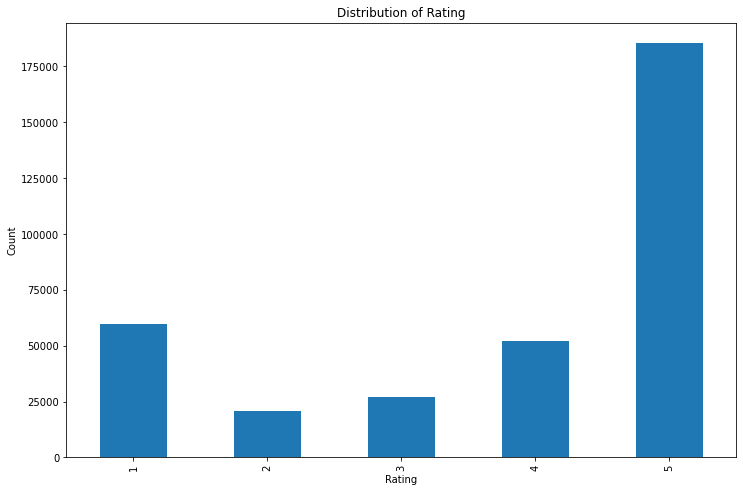

In [15]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(data['Rating'])
data['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

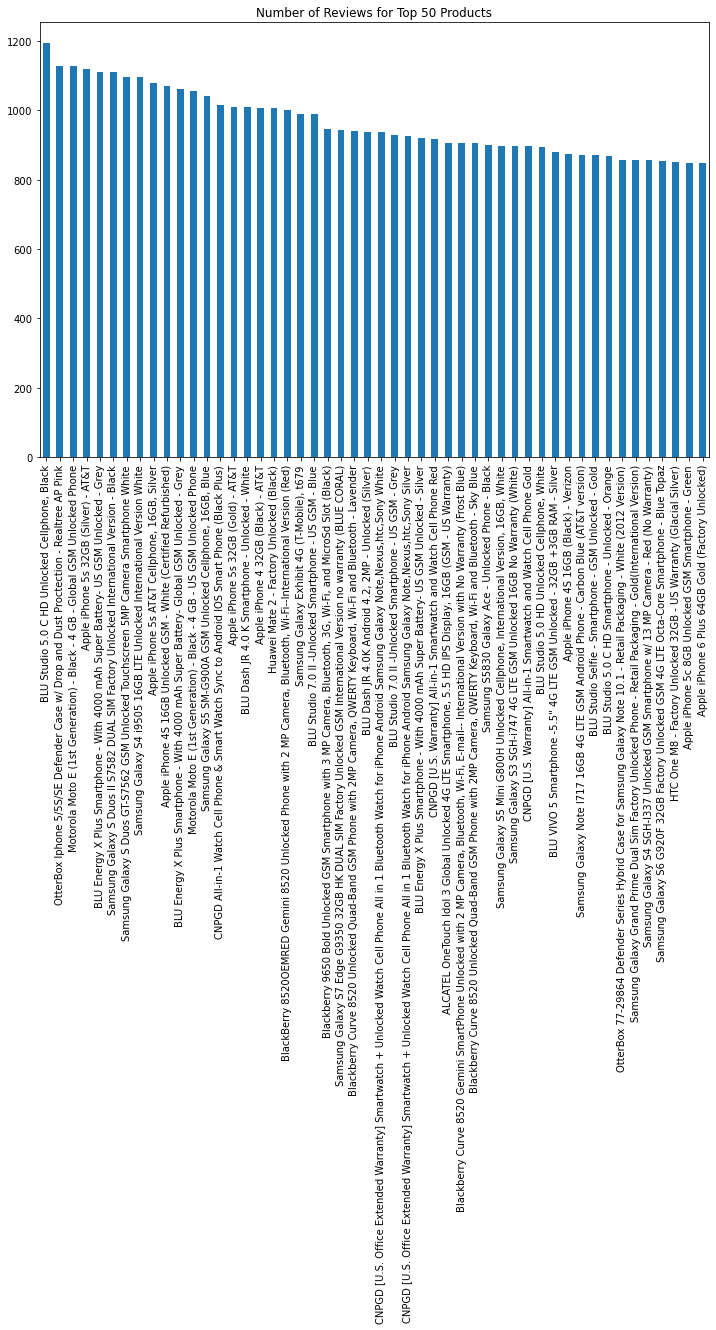

In [16]:
# Plot distribution of number of reviews for top 50 products
products = data["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

Text(0, 0.5, 'Count')

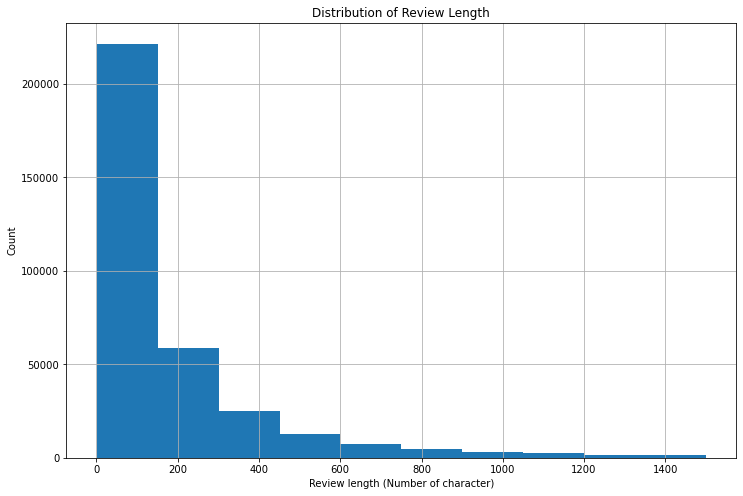

In [17]:
# Plot distribution of review length
review_length = data["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

### Data Preprocessing 
The following text preprocessing is implemented to convert the raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

- remove html tags using BeautifulSoup
- remove non-character such as digits and symbols
- convert to lower case
- remove stop words such as "the" and "and" if needed
- convert to root words by stemming if needed


In [20]:
def CleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
        #stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [22]:
import warnings
warnings.filterwarnings("ignore")
cleaned_review=[]
for i in data['Reviews']:
    cleaned_review.append(CleanText(i))
data['Cleaned Review']=cleaned_review
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Label,Cleaned Review
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,2,i feel so lucky to have found this used phone ...
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",2,nice phone nice up grade from my pantach revue...
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,2,very pleased
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,2,it works good but it goes slow sometimes but i...
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,2,great phone to replace my lost phone the only ...


### Spliting the Dataset into Training and Testing set 
We take our cleaned reviews and try predicted the labels.

In [23]:
 x_train , x_test , y_train , y_test = train_test_split(data['Cleaned Review'] , data['Label'] , test_size = 0.2, random_state = 10 )

### Training our model - Bag of Words Model

There are two methods for analysing the sentiment of the given text. To transform a text into a numerical representation, we must first find a word embedding. Second, we used machine learning algorithms or deep learning architectures to match the numerical representations of text.

Frequency-based embedding, such as the Bag of Words (BoW) model, is a popular approach to word embedding. The BoW model extracts a vocabulary list from a corpus and describes each text using different word counting methods. In this section, we'll look at how well BoW works with supervised learning algorithms. This section's workflow is as follows.

- 1.Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
- 2.Transform review text to numerical representations (feature vectors)
- 3.Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
- 4.Perfomance measure

In [26]:
count_vect = CountVectorizer()
x_train_tf = count_vect.fit_transform(x_train)
print ("Number of features : %d \n" %len(count_vect.get_feature_names()))
print ("Show some feature names : \n", count_vect.get_feature_names())

Number of features : 51834 

Show some feature names : 
 ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc', 'aaaaaaamazing', 'aaaaaand', 'aaaalll', 'aaaannndd', 'aaargh', 'aaarrrgghhhh', 'aab', 'aac', 'aactivate', 'aae', 'aah', 'aahs', 'aall', 'aalus', 'aamazon', 'aand', 'aandd', 'aandns', 'aandve', 'aaps', 'aare', 'aaron', 'aarp', 'aarse', 'aat', 'aazt', 'ab', 'aback', 'abad', 'abandon', 'abando

In [44]:
print (x_train_tf.shape)
print (x_train.shape)

(275606, 51834)
(275606,)


#### Term Frequency (TF) && Inverse Document Frequency (IDF)

Term Frequency: This summarizes how often a given word appears within a document.<br>
Inverse Document Frequency : This Downscales words that appear a lot across Documents.<br>
Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus.In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.<br>
Example: 'The' term appears many times , but it doesnt mean that much . Therefore it is given least weight.

In [45]:
tfidf = TfidfVectorizer(min_df=5)
x_train_tfidf = tfidf.fit_transform(x_train)
print ("Number of features : %d \n" %len(tfidf.get_feature_names()))
print ("Show some feature names : \n", tfidf.get_feature_names()[::100])

Number of features : 18430 

Show some feature names : 
 ['aa', 'accessories', 'acts', 'adored', 'age', 'algunas', 'amazed', 'anker', 'api', 'ar', 'aseguren', 'attempt', 'avi', 'baeria', 'batery', 'beep', 'beter', 'blackverry', 'blunders', 'bos', 'bricks', 'bugginess', 'buzzed', 'camo', 'carge', 'cells', 'cheaper', 'chronic', 'clicks', 'collected', 'communicate', 'compliant', 'condtion', 'consider', 'contrast', 'corre', 'covert', 'crippled', 'cumple', 'damaged', 'deberian', 'defiantly', 'dennis', 'desirable', 'dhcp', 'diligent', 'discoloration', 'dissapointed', 'doesent', 'drag', 'dudasgracias', 'easter', 'elder', 'empty', 'entensity', 'erratically', 'estrellas', 'exceed', 'exhilarate', 'explore', 'faded', 'fault', 'fieldstrip', 'fisrt', 'flowing', 'forgive', 'freesd', 'funciana', 'games', 'gestures', 'glued', 'gr', 'greek', 'gulf', 'handsnow', 'hdandroid', 'herself', 'hola', 'hound', 'iceland', 'imap', 'inboxes', 'indicator', 'inntime', 'integrity', 'intrusive', 'isnt', 'jaw', 'june',

#### Train the model using LinearSVC

In [46]:
x_train_input = tfidf.transform(x_train)
linear_svc = LinearSVC(multi_class='ovr')
linear_svc.fit(x_train_input,y_train)
predictions = linear_svc.predict(tfidf.transform(x_test))

In [51]:
print ("Accuracy of this SVM = " + str(metrics.accuracy_score(y_test, predictions)))
print ("Confusion matrix = " + str(metrics.confusion_matrix(y_test, predictions)))

Accuracy of this SVM = 0.8929348930364867
Confusion matrix = [[14203   221  1601]
 [ 1689  1230  2360]
 [ 1204   302 46092]]
